In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
from scipy.io.matlab.mio import loadmat, savemat
import numpy as np
from PIL import Image
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch import nn, optim
import torch.nn.functional as nnf
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

C:\Users\Nassim\AppData\Local\Temp\ipykernel_11028\1160388593.py:8: DeprecationWarning: Please use `loadmat` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio` namespace is deprecated.
  from scipy.io.matlab.mio import loadmat, savemat
C:\Users\Nassim\AppData\Local\Temp\ipykernel_11028\1160388593.py:8: DeprecationWarning: Please use `savemat` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio` namespace is deprecated.
  from scipy.io.matlab.mio import loadmat, savemat


In [56]:

from typing import Any
import cv2


class toHSV() : 
    def __call__(self, img) -> Any:
        
        return Image.fromarray(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2HSV))

In [68]:
path_pair_img = 'data/photoshoptest'

image_transform = transforms.Compose([
    toHSV(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=path_pair_img, transform=image_transform)

batch_size = 5
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

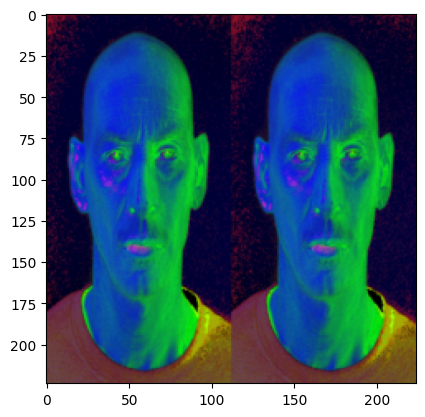

In [71]:
image = dataset[0][0]
image = image.permute(1, 2, 0)
plt.imshow(image.numpy())

In [59]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(46656, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 8)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [61]:
model = LeNet().to(device)
print(model)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=8, bias=True)
)


In [62]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [63]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    #Used to calculate the confusion matrix
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X, y in dataloader:

            Xd, yd = X.to(device), y.to(device)
            pred = model(Xd)
            
            test_loss += loss_fn(pred, yd).item()
            correct += (pred.argmax(1) == yd).type(torch.float).sum().item()
            
            
            y_pred.extend(pred.argmax(1).data.cpu().numpy())
            y_true.extend(y.data.cpu().numpy())

        

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    labels = ["Diffuse", "Edges", "Guassian", "pinch", "Sharpen", "Surface", "Twirl", "Wave"]

    conf_matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
    disp.plot()
    plt.xticks(rotation = 45) 
    plt.show()
    

# Training

In [77]:
epochs = 20

for i in range(1):
    model = LeNet().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    print("CrossValidation : "+str(i)+"\n-------------------------------\n")
    train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)


    # Create the data loaders for training and validation
    train_dataloader = torch.utils.data.DataLoader(
        train_data,
        batch_size=100,
        shuffle=True
    )

    test_dataloader = torch.utils.data.DataLoader(
        test_data,
        batch_size=100,
        shuffle=False
    )
    
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        # test(test_dataloader, model, loss_fn)
    print("Done!")



CrossValidation : 0
-------------------------------

Epoch 1
-------------------------------
loss: 2.084978  [  100/ 5260]
Epoch 2
-------------------------------
loss: 1.545638  [  100/ 5260]
Epoch 3
-------------------------------
loss: 1.166860  [  100/ 5260]
Epoch 4
-------------------------------
loss: 1.228706  [  100/ 5260]
Epoch 5
-------------------------------
loss: 0.949739  [  100/ 5260]
Epoch 6
-------------------------------
loss: 1.039220  [  100/ 5260]
Epoch 7
-------------------------------
loss: 1.031562  [  100/ 5260]
Epoch 8
-------------------------------
loss: 0.735612  [  100/ 5260]
Epoch 9
-------------------------------
loss: 0.924451  [  100/ 5260]
Epoch 10
-------------------------------
loss: 0.895842  [  100/ 5260]
Epoch 11
-------------------------------
loss: 0.619526  [  100/ 5260]
Epoch 12
-------------------------------
loss: 0.580438  [  100/ 5260]
Epoch 13
-------------------------------
loss: 0.500455  [  100/ 5260]
Epoch 14
------------------------

In [78]:
torch.save(model.state_dict(), "./models/model_hsv")

# Testing phase

Test Error: 
 Accuracy: 42.2%, Avg loss: 1.647702 



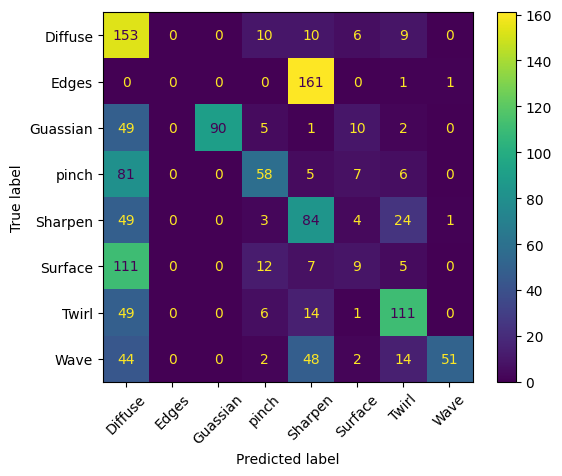

In [79]:
model = LeNet().to(device)
model.load_state_dict(torch.load("./models/model"))
model.eval()
loss_fn = nn.CrossEntropyLoss()

train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

test_dataloader = torch.utils.data.DataLoader(
    test_data,
    batch_size=100,
    shuffle=False
)

test(test_dataloader, model, loss_fn)

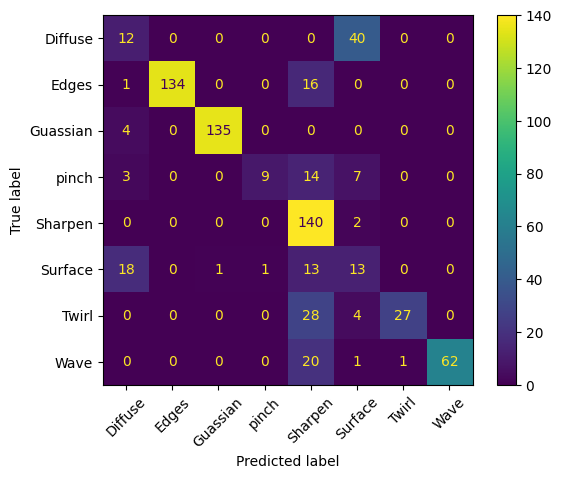

In [67]:
y_true = []
y_pred = []

for X, y in test_dataloader:
    y_true.extend(y.data.cpu().numpy())
    X, y = X.to(device), y.to(device)
    pred = model(X)
    pred = pred.softmax(dim=1)
    y_pred.extend(pred.data.cpu().numpy())
    
y_pred = np.array(y_pred)
y_true = np.array(y_true)
seuil = 0.90
indices = y_pred.max(1) > seuil
y_pred = y_pred[indices].argmax(1)
y_true = y_true[indices]

conf_matrix = confusion_matrix(y_true, y_pred)
labels = ["Diffuse", "Edges", "Guassian", "pinch", "Sharpen", "Surface", "Twirl", "Wave"]
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = labels)
disp.plot()
plt.xticks(rotation = 45) 
plt.show()

In [76]:
transform = transforms.Compose([
    toHSV(),
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Use your normalization values
])

i = Image.open("./data/pair_tmp/final_pair_bb.jpg")
image_tensor = transform(i).unsqueeze(0)
image_tensor = image_tensor.cuda()

with torch.no_grad() : 
    output = model(image_tensor)

_, predicted_class = torch.max(output, 1)

probas = nnf.softmax(output, dim=1)

print("predicted class : ", predicted_class.item())
print("Proba de prédiction : ", probas[0, predicted_class.item()].item())


predicted class :  1
Proba de prédiction :  1.0
